# chatClassifier2

chatClassifier, but with tiktoken tokenizer

## Import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import random
import copy
import csv
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install sentencepiece
import sentencepiece as spm

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense, Input, Flatten, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.6 MB/s eta 0:00:00


## Dataload

In [2]:
data_path = '/content/drive/MyDrive/Colab Notebooks/chatClassifier/KakaoTalkChats.txt'

def txt_to_lst(lst):
    time_period_flag = False
    with open(data_path, 'r') as f:
        for line in tqdm(f.readlines()):
            line = line.strip()

            if line[:len(start_date)]==start_date:
                time_period_flag = True

            if time_period_flag==True and line[:len(tda_end_date)]==tda_end_date:
                break

            if time_period_flag==True:
                if line[:2] == '20' and '년' in line and '월' in line and '일' in line and ('오전' in line or '오후' in line) and line.count(':') == 2:

                    index_comma = line.index(',')
                    index_colon = line.index(':', index_comma)
                    name = line[index_comma+2:index_colon-1]

                    text = line[index_colon+2:]
                    lst.append([name, text])

In [3]:
start_date = '2022년 1월 1일'
tda_end_date = '2023년 1월 1일'

train_lst = []
txt_to_lst(train_lst)
len(train_lst)

 98%|█████████▊| 3032549/3097114 [00:06<00:00, 468671.52it/s]


960588

In [4]:
train_df = pd.DataFrame(train_lst, columns=['name', 'text'])

In [5]:
counts = train_df['name'].value_counts()
counts_df = counts.sort_values(ascending=False).reset_index()
counts_df.columns = ['name', 'count']

bot_index = list(counts_df['name']).index("방장봇")
participants = list(counts_df['name'][:bot_index+1])
print(len(participants))
counts_df = counts_df[counts_df['name'].isin(participants)]

counts_df['index'] = counts_df.index
counts_df = counts_df.drop(columns=['count'])
name2index = counts_df.set_index('name').to_dict()['index']
index2name = counts_df.set_index('index').to_dict()['name']

62


In [6]:
print(name2index)
print(index2name)

{'爱德华/잠실르엘판매중/25': 0, '랄프': 1, '박찬홍/ 주생아/엉아들 잘부탁해~': 2, 'Dool Lee/도시빈민/외노자': 3, '원정': 4, '안정현 / 도태솔로': 5, '李在明/중앙대/인천/의원': 6, '라테라테': 7, '이상덕/울면서기도하는남쟈': 8, 'Jinyoung. woo': 9, '심언니': 10, '돌돌삼/머구/다주택': 11, 'Jihan/악성부채인생/겨울이길다': 12, 'Min Kim': 13, '정대만': 14, 'DG': 15, '이준국': 16, 'kich': 17, '오징어': 18, '최재경': 19, '지수/내년 시드 2chb 목표': 20, '촉촉': 21, '민수': 22, '리플 / 이정우': 23, '김반포': 24, '강영광': 25, '호빵': 26, '🌸슈롱': 27, '홍': 28, '지성원': 29, '송준기/망천/경자야~~': 30, '권인호': 31, 'malarka': 32, 'kim hs': 33, 'Jin': 34, '장재원': 35, '엔젤': 36, '밍기찡': 37, '곽병민': 38, '스갱🐻니니': 39, '퐝호': 40, '김동석': 41, 'Edward Jeong': 42, '최원규': 43, '박준권/서울/매일힘든남자': 44, '최주명': 45, '김민중/골프포기': 46, 'Jack Kim': 47, '김선광': 48, 'jiwon / 평촌': 49, '김종익': 50, '박경용': 51, '박용석': 52, '우천': 53, 'Dongwhane Lee': 54, '고기윤/일산': 55, '김승용': 56, 'John Perry': 57, '은경': 58, 'Myunee': 59, '박건령': 60, '방장봇': 61}
{0: '爱德华/잠실르엘판매중/25', 1: '랄프', 2: '박찬홍/ 주생아/엉아들 잘부탁해~', 3: 'Dool Lee/도시빈민/외노자', 4: '원정', 5: '안정현 / 도태솔로', 6: '李在明/중앙대/인천/의원', 7: '라테라테', 8:

In [7]:
train_df = train_df[train_df['name'].isin(participants)]
len(train_df)

938634

In [8]:
start_date = '2023년 1월 1일'
tda_end_date = '2023년 2월 1일'

test_lst = []
txt_to_lst(test_lst)
len(test_lst)

100%|█████████▉| 3094946/3097114 [00:01<00:00, 1720045.12it/s]


53026

In [9]:
test_df = pd.DataFrame(test_lst, columns=['name', 'text'])

In [10]:
test_df = test_df[test_df['name'].isin(participants)]
len(test_df)

51303

In [11]:
with open('gom22.txt', 'w', encoding='utf8') as f:
    f.write('\n'.join(train_df['text']))

## Tokenizer

In [13]:
spm.SentencePieceTrainer.Train('--input=gom22.txt --model_prefix=gom22 --vocab_size=10000 --model_type=bpe --max_sentence_length=100')

In [14]:
vocab_list = pd.read_csv('gom22.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
print(len(vocab_list))
vocab_list.sample(10)

10000


,0,1
3673,▁아는데,-3670
9322,펩,-9319
1934,대요,-1931
7685,▁그렇다면,-7682
7832,감을,-7829
9726,뮨,-9723
2214,▁영화,-2211
1651,▁가져,-1648
7891,콘,-7888
1140,▁애들,-1137


In [15]:
sp = spm.SentencePieceProcessor()
vocab_file = "gom22.model"
sp.load(vocab_file)

True

In [12]:
!pip install tiktoken
import tiktoken
enc = tiktoken.encoding_for_model("gpt-4")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 20.4 MB/s eta 0:00:00


In [16]:
test_shuffle = copy.deepcopy(test_lst)
random.shuffle(test_shuffle)
for line in test_shuffle[:5]:
    print(line[0])
    print(line[1])
    print(f"sentencepiece: {sp.encode_as_pieces(line[1])}")
    print(f"sentencepiece: {sp.encode_as_ids(line[1])}")
    l = []
    for i in enc.encode(line[1]):
        l.append(enc.decode([i]))
    print(f"tiktoken: {l}")
    # print(f"tiktoken: {enc.decode(enc.encode(line[1]))}")
    print(f"tiktoken: {enc.encode(line[1])}")
    print()

Jihan/악성부채인생/겨울이길다
아침부터 도파민
sentencepiece: ['▁아침부터', '▁도', '파', '민']
sentencepiece: [4695, 160, 8044, 8047]
tiktoken: ['아', '�', '�', '부', '터', ' �', '�', '�', '�', '�', '�']
tiktoken: [54059, 49072, 101, 64189, 34961, 65905, 226, 67218, 234, 50273, 120]

곽병민
제가 사랑의 매로 감싸드릴수 있는데
sentencepiece: ['▁제가', '▁사랑', '의', '▁매', '로', '▁감', '싸', '드릴', '수', '▁있는데']
sentencepiece: [203, 1235, 7929, 175, 7892, 47, 8139, 2282, 7916, 526]
tiktoken: ['제', '가', ' 사', '�', '�', '의', ' �', '�', '로', ' �', '�', '�', '�', '드', '�', '�', '수', ' 있는', '�', '��']
tiktoken: [38187, 20565, 33229, 39519, 239, 21028, 34085, 97, 17835, 17196, 238, 22254, 116, 30446, 20701, 112, 24140, 65621, 167, 43002]

지성원
외울때까지 보게될듯
sentencepiece: ['▁외', '울', '때까지', '▁보', '게', '될듯']
sentencepiece: [336, 8102, 3348, 34, 7901, 3960]
tiktoken: ['�', '�', '�', '�', '�', '��', '�', '�', '지', ' 보', '게', '�', '�', '�', '�']
tiktoken: [59399, 116, 15269, 116, 167, 48478, 84291, 234, 22035, 64432, 58901, 33943, 254, 21819, 107]

kim hs
尹대

## Dataset (sentencepiece)

In [42]:
train_name = train_df['name'].values.tolist()
y_train = []
for y in train_name:
    y_train.append(name2index[y])

train_text = train_df['text'].values.tolist()
X_train = []
for X in train_text:
    X_train.append(sp.encode_as_ids(X))

In [43]:
print(len(X_train))
print(len(y_train))

938634
938634


In [44]:
test_name = test_df['name'].values.tolist()
y_test = []
for y in test_name:
    y_test.append(name2index[y])

test_text = test_df['text'].values.tolist()
X_test = []
for X in test_text:
    X_test.append(sp.encode_as_ids(X))

In [45]:
print(len(X_test))
print(len(y_test))

51303
51303


388
6.092775245729432


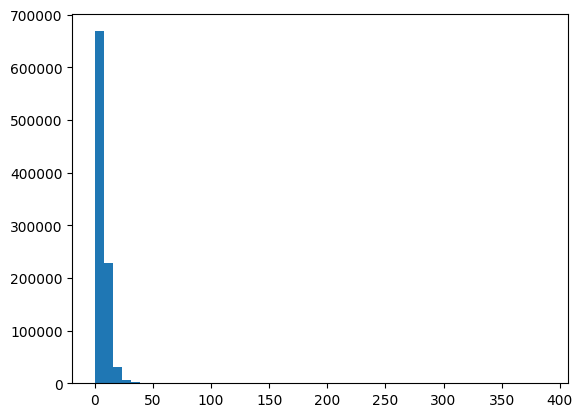

In [46]:
print(max(len(X) for X in X_train))
print(sum(map(len, X_train))/len(X_train))

plt.hist([len(X) for X in X_train], bins=50)
plt.show()

In [47]:
pad_maxlen = 25
count = 0
for X in X_train:
    if len(X)<=pad_maxlen:
        count += 1
print(count/len(X_train))

0.9919212387362912


In [48]:
X_train = pad_sequences(X_train, maxlen=pad_maxlen)
print(X_train.shape)
y_train = np.array(y_train)
y_train = to_categorical(y_train, len(participants))
print(y_train.shape)

X_test = pad_sequences(X_test, maxlen=pad_maxlen)
print(X_test.shape)
y_test = np.array(y_test)
y_test = to_categorical(y_test, len(participants))
print(y_test.shape)

(938634, 25)
(938634, 62)
(51303, 25)
(51303, 62)


## Model (sentencepiece)

In [49]:
embedding_dim = 128
dropout_ratio = (0.5, 0.8)
num_filters = 128
hidden_units = 128

In [50]:
model_input = Input(shape=(pad_maxlen,))
z = Embedding(len(vocab_list), 
              embedding_dim, 
              input_length=pad_maxlen, 
              name="embedding")(model_input)
z = Dropout(dropout_ratio[0])(z)

In [51]:
conv_blocks = []

for sz in [3, 4, 5]:
    conv = Conv1D(filters=num_filters,
                  kernel_size=sz,
                  padding="valid",
                  activation="relu",
                  strides=1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

In [52]:
z = Concatenate()(conv_blocks) if len(conv_blocks)>1 else conv_blocks[0]
z = Dropout(dropout_ratio[1])(z)
z = Dense(hidden_units, activation="relu")(z)
model_output = Dense(len(participants), activation="softmax")(z)

model = Model(model_input, model_output)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
# mc = ModelCheckpoint('gom22.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.2, verbose=2, callbacks=[es, mc])

## Test (sentencepiece)

In [53]:
loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/chatClassifier/gom22.h5')
print(f"Test accuracy: {loaded_model.evaluate(X_test, y_test)[1]:.4f}")

1604/1604 [==============================] - 5s 3ms/step - loss: 2.8331 - acc: 0.2918
Test accuracy: 0.2918


## Inference (sentencepiece)

In [66]:
r = random.randint(0, len(X_test))
X = X_test[r]
X_lst = X.tolist()
pieces = []
for i in X_lst:
    if i!=0:
        pieces.append(sp.IdToPiece(i))

sentence = ''.join(i for i in pieces)
sentence = sentence.replace('▁', ' ')
if sentence[0]==' ':
    sentence = sentence[1:]
print(sentence)

X = np.expand_dims(X, axis=0)
pred = loaded_model.predict(X)
# max_idx = np.argmax(pred)
five_idxs = np.argsort(pred)
five_idxs = five_idxs.tolist()
five_idxs = five_idxs[0]
five_idxs = five_idxs[::-1]
five_idxs = five_idxs[:5]

for rank, idx in enumerate(five_idxs):
    print(f'{rank+1}) {index2name[idx]}: {pred[0][idx]*100:.2f}%')

이거 대형마트에서도 개당 만원 넘습니다
1/1 [==============================] - 0s 19ms/step
1) 爱德华/잠실르엘판매중/25: 38.96%
2) 정대만: 6.96%
3) 랄프: 5.37%
4) 안정현 / 도태솔로: 4.47%
5) kich: 4.05%


In [67]:
sentence = '존예디컵 여름 풀파티 하기 딱이긴 하겠네요'
print(sentence)

sentence = [sp.encode_as_ids(sentence)]
sentence = pad_sequences(sentence, maxlen=pad_maxlen)
print(sentence)
sentence_lst = sentence.tolist()
pieces = []
for i in sentence_lst[0]:
    pieces.append(sp.IdToPiece(i))
sentence_joined = ''.join(i for i in pieces)
print(sentence_joined)
pred = loaded_model.predict(sentence)
# max_idx = np.argmax(pred)
five_idxs = np.argsort(pred)
five_idxs = five_idxs.tolist()
five_idxs = five_idxs[0]
five_idxs = five_idxs[::-1]
five_idxs = five_idxs[:5]

for rank, idx in enumerate(five_idxs):
    print(f'{rank+1}) {index2name[idx]}: {pred[0][idx]*100:.2f}%')

존예디컵 여름 풀파티 하기 딱이긴 하겠네요
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0 1560 3002  628 4522 3198  485 1187   19  403]]
<unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk><unk>▁존예디컵▁여름▁풀파티▁하기▁딱이긴▁하겠네요
1/1 [==============================] - 0s 19ms/step
1) 爱德华/잠실르엘판매중/25: 54.90%
2) Jinyoung. woo: 7.72%
3) 정대만: 4.46%
4) 심언니: 4.13%
5) kich: 2.99%


In [75]:
for i in range(20):
    print(sp.IdToPiece(i))

<unk>
<s>
</s>
..
▁이
ᄏᄏ
▁사
니다
▁아
▁그
티콘
▁이모
▁이모티콘
▁사진
...
▁ᄏᄏ
▁선
▁안
▁.
▁하


## Dataset (tiktoken)

In [68]:
train_name = train_df['name'].values.tolist()
y_train = []
for y in train_name:
    y_train.append(name2index[y])

train_text = train_df['text'].values.tolist()
X_train = []
for X in train_text:
    X_train.append(enc.encode(X))

In [69]:
print(len(X_train))
print(len(y_train))

938634
938634


In [70]:
test_name = test_df['name'].values.tolist()
y_test = []
for y in test_name:
    y_test.append(name2index[y])

test_text = test_df['text'].values.tolist()
X_test = []
for X in test_text:
    X_test.append(enc.encode(X))

In [71]:
print(len(X_test))
print(len(y_test))

51303
51303


832
14.304247448952413


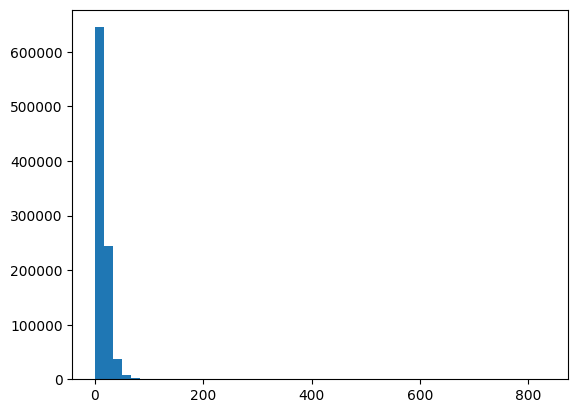

In [72]:
print(max(len(X) for X in X_train))
print(sum(map(len, X_train))/len(X_train))

plt.hist([len(X) for X in X_train], bins=50)
plt.show()

In [73]:
pad_maxlen = 50
count = 0
for X in X_train:
    if len(X)<=pad_maxlen:
        count += 1
print(count/len(X_train))

0.988889172989685


In [74]:
X_train = pad_sequences(X_train, maxlen=pad_maxlen)
print(X_train.shape)
y_train = np.array(y_train)
y_train = to_categorical(y_train, len(participants))
print(y_train.shape)

X_test = pad_sequences(X_test, maxlen=pad_maxlen)
print(X_test.shape)
y_test = np.array(y_test)
y_test = to_categorical(y_test, len(participants))
print(y_test.shape)

(938634, 50)
(938634, 62)
(51303, 50)
(51303, 62)


## Model (tiktoken)

In [31]:
embedding_dim = 128
dropout_ratio = (0.5, 0.8)
num_filters = 128
hidden_units = 128

In [32]:
model_input = Input(shape=(pad_maxlen,))
z = Embedding(len(vocab_list), 
              embedding_dim, 
              input_length=pad_maxlen, 
              name="embedding")(model_input)
z = Dropout(dropout_ratio[0])(z)

In [33]:
conv_blocks = []

for sz in [3, 4, 5]:
    conv = Conv1D(filters=num_filters,
                  kernel_size=sz,
                  padding="valid",
                  activation="relu",
                  strides=1)(z)
    conv = GlobalMaxPooling1D()(conv)
    conv_blocks.append(conv)

## Train (tiktoken)

In [35]:
z = Concatenate()(conv_blocks) if len(conv_blocks)>1 else conv_blocks[0]
z = Dropout(dropout_ratio[1])(z)
z = Dense(hidden_units, activation="relu")(z)
model_output = Dense(len(participants), activation="softmax")(z)

model = Model(model_input, model_output)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('gom22.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.2, verbose=2, callbacks=[es, mc])

Epoch 1/10

Epoch 1: val_acc improved from -inf to 0.16693, saving model to gom22.h5
11733/11733 - 79s - loss: 3.2572 - acc: 0.1624 - val_loss: 3.2503 - val_acc: 0.1669 - 79s/epoch - 7ms/step
Epoch 2/10

Epoch 2: val_acc did not improve from 0.16693
11733/11733 - 66s - loss: 3.1980 - acc: 0.1706 - val_loss: 3.2322 - val_acc: 0.1648 - 66s/epoch - 6ms/step
Epoch 3/10

Epoch 3: val_acc did not improve from 0.16693
11733/11733 - 62s - loss: 3.1840 - acc: 0.1724 - val_loss: 3.2392 - val_acc: 0.1626 - 62s/epoch - 5ms/step
Epoch 4/10

Epoch 4: val_acc improved from 0.16693 to 0.16694, saving model to gom22.h5
11733/11733 - 61s - loss: 3.1775 - acc: 0.1737 - val_loss: 3.2505 - val_acc: 0.1669 - 61s/epoch - 5ms/step
Epoch 5/10

Epoch 5: val_acc did not improve from 0.16694
11733/11733 - 61s - loss: 3.1740 - acc: 0.1740 - val_loss: 3.2789 - val_acc: 0.1635 - 61s/epoch - 5ms/step
Epoch 6/10

Epoch 6: val_acc improved from 0.16694 to 0.16817, saving model to gom22.h5
11733/11733 - 61s - loss: 3.17

## Test (tiktoken)

In [36]:
loaded_model = load_model('./gom22.h5')
print(f"Test accuracy: {loaded_model.evaluate(X_test, y_test)[1]:.4f}")

1604/1604 [==============================] - 5s 3ms/step - loss: 3.1619 - acc: 0.2117
Test accuracy: 0.2117


## Inference (tiktoken)

In [37]:
r = random.randint(0, len(X_test))
X = X_test[r]
X_lst = X.tolist()
# pieces = []
# for i in X_lst:
#     if i!=0:
#         pieces.append(sp.IdToPiece(i))

# sentence = ''.join(i for i in pieces)
# sentence = sentence.replace('▁', ' ')
# if sentence[0]==' ':
#     sentence = sentence[1:]
sentence = enc.decode(X_lst)
print(sentence)

X = np.expand_dims(X, axis=0)
pred = loaded_model.predict(X)
# max_idx = np.argmax(pred)
five_idxs = np.argsort(pred)
five_idxs = five_idxs.tolist()
five_idxs = five_idxs[0]
five_idxs = five_idxs[::-1]
five_idxs = five_idxs[:5]

for rank, idx in enumerate(five_idxs):
    print(f'{rank+1}) {index2name[idx]}: {pred[0][idx]*100:.2f}%')

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!배고파쓰
1/1 [==============================] - 0s 212ms/step
1) Dool Lee/도시빈민/외노자: 12.20%
2) 爱德华/잠실르엘판매중/25: 8.65%
3) 원정: 8.62%
4) 랄프: 7.76%
5) 정대만: 3.79%


In [38]:
sentence = '존예디컵 여름 풀파티 하기 딱이긴 하겠네요'
print(sentence)

# sentence = [sp.encode_as_ids(sentence)]
sentence = [enc.encode(sentence)]
sentence = pad_sequences(sentence, maxlen=pad_maxlen)
print(sentence)
print(enc.decode(sentence[0]))
pred = loaded_model.predict(sentence)
# max_idx = np.argmax(pred)
five_idxs = np.argsort(pred)
five_idxs = five_idxs.tolist()
five_idxs = five_idxs[0]
five_idxs = five_idxs[::-1]
five_idxs = five_idxs[:5]

for rank, idx in enumerate(five_idxs):
    print(f'{rank+1}) {index2name[idx]}: {pred[0][idx]*100:.2f}%')

존예디컵 여름 풀파티 하기 딱이긴 하겠네요
[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0   168 91657 36092   230 90335
    168   119   113 84618 64254 10997   240   222 67218   234   169   233
    108 55000 21121 77597   109 13094 18202   112 55000 28740   254 76242
     97 36811]]
!!!!!!!!!!!!!!!!!!!존예디컵 여름 풀파티 하기 딱이긴 하겠네요
1/1 [==============================] - 0s 20ms/step
1) 爱德华/잠실르엘판매중/25: 14.20%
2) 박찬홍/ 주생아/엉아들 잘부탁해~: 8.95%
3) 랄프: 6.44%
4) 이상덕/울면서기도하는남쟈: 5.57%
5) kich: 4.81%


In [40]:
for i in range(20):
    print(enc.decode([i]))

!
"
#
$
%
&
'
(
)
*
+
,
-
.
/
0
1
2
3
4
